In [ ]:
!pip install pandas
!pip install numpy
!pip install tensorflow==2.15.0
!pip install tensorflow-addons
!pip install vit-keras
!pip install matplotlib
!pip install scikit-learn

/usr/local/lib/python3.11/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 4, 4
  warnings.warn(


Epoch 1/3
225/225 [==============================] - 1203s 5s/step - loss: 2.0428 - accuracy: 0.1969 - val_loss: 1.8371 - val_accuracy: 0.2246 - lr: 1.0000e-04
Epoch 2/3
225/225 [==============================] - 1099s 5s/step - loss: 1.8603 - accuracy: 0.2225 - val_loss: 1.8038 - val_accuracy: 0.2446 - lr: 1.0000e-04
Epoch 3/3
113/113 [==============================] - 203s 2s/step - loss: 1.7958 - accuracy: 0.2463
🎯 Final Validation Accuracy: 24.63%


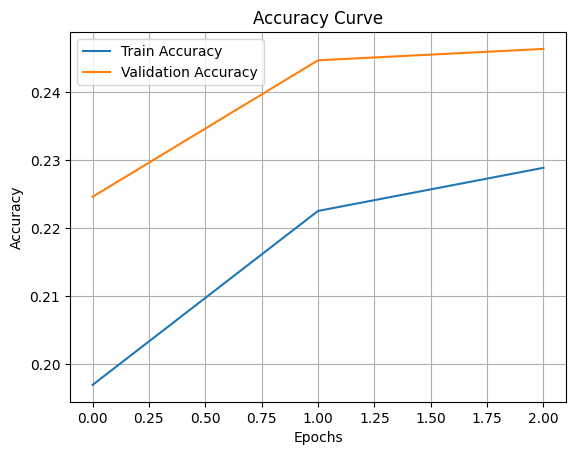

113/113 [==============================] - 210s 2s/step


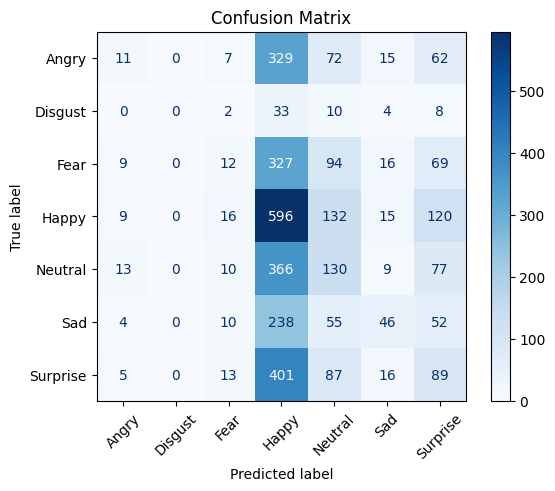

In [ ]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import tensorflow as tf
from vit_keras import vit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# LOAD & PREPROCESS DATA
def load_data(csv_file):
    df = pd.read_csv(csv_file)
    image_size = 64

    # Encode emotion labels
    label_encoder = LabelEncoder()
    df['emotion'] = label_encoder.fit_transform(df['emotion'])
    num_classes = len(label_encoder.classes_)

    # Convert pixel string to image arrays
    X = np.array([np.array(row.split(), dtype=np.uint8).reshape(image_size, image_size, 1) for row in df["pixels"]])
    X = np.repeat(X, 3, axis=-1) / 255.0  # Convert to RGB and normalize
    y = to_categorical(df["emotion"], num_classes=num_classes)

    return X, y, num_classes, label_encoder

# Load the FER2013 dataset
X, y, num_classes, label_encoder = load_data("/content/drive/MyDrive/EmotionLens/dataset/new_splitted_64*64.csv")

# Split into train/val
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# LOAD PRETRAINED ViT MODEL
vit_model = vit.vit_b16(
    image_size=64,
    pretrained=True,
    include_top=False,
    pretrained_top=False
)
vit_model.trainable = False  # Freeze for now

# BUILD FINAL MODEL
inputs = tf.keras.Input(shape=(64, 64, 3))
x = vit_model(inputs)

# Flatten the output from the ViT model
x = tf.keras.layers.Flatten()(x)  # Flatten the output to 1D
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# TRAINING CALLBACKS
early_stop = EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True, verbose=1)
lr_schedule = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, verbose=1, min_lr=1e-6)

# TRAIN MODEL
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,  # You can increase this for better training
    batch_size=64,
    callbacks=[early_stop, lr_schedule],
    verbose=1
)

# SAVE MODEL
model.save("vit_emotion_transformer.keras")

# EVALUATE MODEL
loss, acc = model.evaluate(X_val, y_val)
print(f"🎯 Final Validation Accuracy: {acc * 100:.2f}%")

# PLOT ACCURACY CURVE
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# CONFUSION MATRIX
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()